# HMEQ Analysis

In [1]:
import pandas as pd
from sas7bdat import SAS7BDAT
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer, scale, StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
%matplotlib inline

hmeq=pd.read_csv('/opt/sasinside/DemoData/HMEQ.csv')
hmeq.head()

#Set variables for later use
target="BAD"
class_inputs    = ['IMP_JOB_Office', 'IMP_JOB_Other', 'IMP_JOB_ProfExe', 'IMP_JOB_Sales',
                   'IMP_JOB_Self', 'IMP_REASON_HomeImp']
interval_inputs = ["IMP_CLAGE", "IMP_CLNO", "IMP_DEBTINC", "LOAN", 
                   "IMP_MORTDUE", "IMP_VALUE", "IMP_YOJ", "IMP_NINQ", "IMP_DEROG", "IMP_DELINQ"]
class_vars      = [target] + class_inputs
all_inputs      = interval_inputs + class_inputs

In [2]:
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


### Character Variable Frequency

In [3]:
hmeq['REASON'].value_counts(), hmeq['JOB'].value_counts()

(DebtCon    3928
 HomeImp    1780
 Name: REASON, dtype: int64, Other      2388
 ProfExe    1276
 Office      948
 Mgr         767
 Self        193
 Sales       109
 Name: JOB, dtype: int64)

### Missing Values

In [4]:
hmeq[hmeq.columns].isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

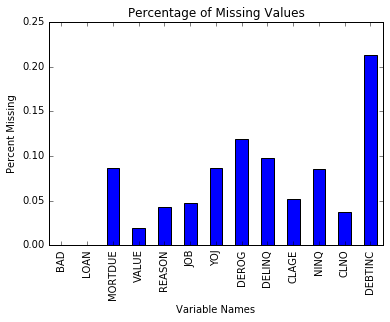

In [5]:
tbl_forplot = pd.Series((hmeq[hmeq.columns].isnull().sum())/len(hmeq), index=hmeq.columns)
ax = tbl_forplot.plot(
  kind  ='bar', 
  title ='Percentage of Missing Values'
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names')
plt.show()

### Imputation of Character Variables

In [6]:
hmeq['IMP_REASON'] = hmeq['REASON'].fillna('DebtCon')
hmeq['IMP_JOB'] = hmeq['JOB'].fillna('Other')

In [7]:
mean_imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
mean=pd.DataFrame(mean_imp.fit_transform(hmeq[['CLAGE','MORTDUE','NINQ','DEROG']]),
                  columns=['IMP_CLAGE','IMP_MORTDUE','IMP_NINQ','IMP_DEROG'])

median_imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
median = pd.DataFrame(median_imp.fit_transform(hmeq[['DELINQ','VALUE','CLNO','DEBTINC','YOJ']]), 
                      columns=['IMP_DELINQ','IMP_VALUE','IMP_CLNO','IMP_DEBTINC','IMP_YOJ'])

hmeq = pd.concat([hmeq, mean, median], axis=1)
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,IMP_JOB,IMP_CLAGE,IMP_MORTDUE,IMP_NINQ,IMP_DEROG,IMP_DELINQ,IMP_VALUE,IMP_CLNO,IMP_DEBTINC,IMP_YOJ
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,Other,94.366667,25860.0000,1.000000,0.00000,0.0,39025.0,9.0,0.524499,10.5
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,...,Other,121.833333,70053.0000,0.000000,0.00000,2.0,68400.0,14.0,0.524499,7.0
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,Other,149.466667,13500.0000,1.000000,0.00000,0.0,16700.0,10.0,0.524499,4.0
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Other,179.766275,73760.8172,1.186055,0.25457,0.0,60000.0,16.0,0.524499,0.0
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,Office,93.333333,97800.0000,0.000000,0.00000,0.0,112000.0,14.0,0.524499,3.0


### Stratified Random Sample

In [8]:
stratified=StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=1234)
stratification = list(stratified.split(hmeq, hmeq['BAD']))

hmeq['SPLIT'] = (hmeq.index.isin(stratification[0][0])).astype(int)
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,IMP_CLAGE,IMP_MORTDUE,IMP_NINQ,IMP_DEROG,IMP_DELINQ,IMP_VALUE,IMP_CLNO,IMP_DEBTINC,IMP_YOJ,SPLIT
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,94.366667,25860.0000,1.000000,0.00000,0.0,39025.0,9.0,0.524499,10.5,0
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,...,121.833333,70053.0000,0.000000,0.00000,2.0,68400.0,14.0,0.524499,7.0,1
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,149.466667,13500.0000,1.000000,0.00000,0.0,16700.0,10.0,0.524499,4.0,0
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,179.766275,73760.8172,1.186055,0.25457,0.0,60000.0,16.0,0.524499,0.0,1
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,93.333333,97800.0000,0.000000,0.00000,0.0,112000.0,14.0,0.524499,3.0,1


### Check Stratification

In [9]:
splits = hmeq.groupby('SPLIT')
print(splits['BAD'].mean())
print(hmeq['BAD'].mean())

SPLIT
0    0.199664
1    0.199425
Name: BAD, dtype: float64
0.199496644295302


### Encode Character Variables

In [10]:
hmeq=  pd.concat([hmeq, pd.get_dummies(hmeq[['IMP_JOB','IMP_REASON']],drop_first=True)], axis=1)

#See resulting columns
hmeq.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'IMP_REASON', 'IMP_JOB',
       'IMP_CLAGE', 'IMP_MORTDUE', 'IMP_NINQ', 'IMP_DEROG', 'IMP_DELINQ',
       'IMP_VALUE', 'IMP_CLNO', 'IMP_DEBTINC', 'IMP_YOJ', 'SPLIT',
       'IMP_JOB_Office', 'IMP_JOB_Other', 'IMP_JOB_ProfExe', 'IMP_JOB_Sales',
       'IMP_JOB_Self', 'IMP_REASON_HomeImp'],
      dtype='object')

# Modeling

In [11]:
#Helper variables
X_train=hmeq[all_inputs][hmeq['SPLIT']==1]
Y_train=hmeq['BAD'][hmeq['SPLIT']==1]
X_valid=hmeq[all_inputs][hmeq['SPLIT']==0]
Y_valid=hmeq['BAD'][hmeq['SPLIT']==0]

#Max 1, Min 0 Neural Net
scaler = StandardScaler()  
scaler.fit(X_train)  
X_ss_train = scaler.transform(X_train)
X_ss_valid = scaler.transform(X_valid)

roc_dct = dict()

### Neural Network

In [12]:
nnet = MLPClassifier(solver='lbgfs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
nnet.fit(X_ss_train, Y_train)

valid_nn_pred = nnet.predict(X_ss_valid) #Uses .5 cutoff
nn_prob = nnet.predict_proba(X_ss_valid)[:,1]

validation_matrix = confusion_matrix(Y_valid, valid_nn_pred)
misclassification = 1 - accuracy_score(Y_valid, valid_nn_pred)

print("Confusion Matrix NN\n", validation_matrix, "\n")
print( "Misclassification NN\n", misclassification,)

roc_dct['Neural Network'] = (misclassification, nn_prob)

Confusion Matrix NN
 [[1362   69]
 [ 133  224]] 

Misclassification NN
 0.112975391499


### Logistic Regression

In [13]:
lm = LogisticRegression(C=1)
lm.fit(X_train, Y_train)

valid_lm_pred = lm.predict(X_valid)
lm_prob=lm.predict_proba(X_valid)[:,1]

misclassification = 1 -accuracy_score(Y_valid, valid_lm_pred)
validation_matrix = confusion_matrix(Y_valid, valid_lm_pred)

print("Confusion Matrix LM\n", validation_matrix, "\n")
print( "Misclassification LM\n", misclassification,)

roc_dct['Logistic Regression'] = (misclassification, lm_prob)

Confusion Matrix LM
 [[1376   55]
 [ 229  128]] 

Misclassification LM
 0.158836689038


### Gradient Boosting

In [14]:
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)

valid_gb_pred=gb.predict(X_valid)
gb_prob = gb.predict_proba(X_valid)[:,1]

validation_matrix=confusion_matrix(Y_valid, valid_gb_pred)
misclassification = 1 - accuracy_score(Y_valid, valid_gb_pred)

print("Confusion Matrix GB\n", validation_matrix, "\n")
print( "Misclassification GB\n", misclassification,)

roc_dct['Gradient Boosting'] = (misclassification, gb_prob)

Confusion Matrix GB
 [[1382   49]
 [ 132  225]] 

Misclassification GB
 0.101230425056


### Support Vector

In [15]:
sv_m = SVC(kernel='rbf', probability=True)
sv_m.fit(X_train, Y_train)

valid_svm_pred = sv_m.predict(X_valid)
svm_prob=sv_m.predict_proba(X_valid)[:,1]

validation_matrix = confusion_matrix(Y_valid, valid_svm_pred)
misclassification = 1 - accuracy_score(Y_valid, valid_svm_pred)

print("Confusion Matrix SVM\n", validation_matrix, "\n")
print( "Misclassification SVM\n", misclassification,)

roc_dct['Support Vector'] = (misclassification, svm_prob)

Confusion Matrix SVM
 [[1431    0]
 [ 357    0]] 

Misclassification SVM
 0.19966442953


### Random Forest

In [16]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(X_train, Y_train)

valid_rf_pred=rf.predict(X_valid)
rf_prob=rf.predict_proba(X_valid)[:,1]

validation_matrix=confusion_matrix(Y_valid, valid_rf_pred)
misclassification = 1 - accuracy_score(Y_valid, valid_rf_pred)

print("Confusion Matrix RF\n", validation_matrix, "\n")
print( "Misclassification RF\n", misclassification, "\n")

oob_error = rf.oob_score_  #Lists accuracy, 1-oob = misclassification
print("Misclassification - RF OOB\n",1 - oob_error)

roc_dct['Random Forest'] = (misclassification, rf_prob)

Confusion Matrix RF
 [[1382   49]
 [ 109  248]] 

Misclassification RF
 0.0883668903803 

Misclassification - RF OOB
 0.0958772770853


### Decision Tree

In [17]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, Y_train)

valid_dt_pred=dt.predict(X_valid)
dt_prob=dt.predict_proba(X_valid)[:,1]

validation_matrix=confusion_matrix(Y_valid, valid_dt_pred)
misclassification = 1 - accuracy_score(Y_valid, valid_dt_pred)

print("Confusion Matrix DT\n", validation_matrix, "\n")
print( "Misclassification DT\n", misclassification, "\n")

roc_dct['Decision Tree'] = (misclassification, dt_prob)

Confusion Matrix DT
 [[1372   59]
 [ 169  188]] 

Misclassification DT
 0.127516778523 



# Compare Models

### Misclassification Matrix

In [29]:
test=pd.DataFrame(((key, value[0]) for key, value in roc_dct.items()), columns=['Model', 'Misclassification Rate'])
test.sort_values('Misclassification Rate')

,Model,Misclassification Rate
0,Random Forest,0.088367
1,Gradient Boosting,0.101230
2,Neural Network,0.112975
4,Decision Tree,0.127517
3,Logistic Regression,0.158837
5,Support Vector,0.199664


### Generate ROC Curve

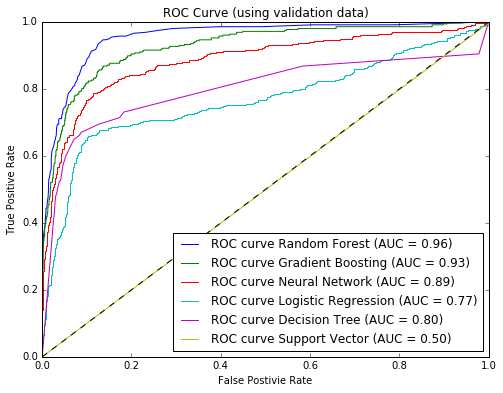

In [19]:
plt.figure(figsize=(8, 6))
for key,value in roc_dct.items():
    roc = roc_auc_score(Y_valid, value[1])
    fpr, tpr, thr = roc_curve(Y_valid, value[1])
    plt.plot(fpr, tpr,  label='ROC curve %s (AUC = %0.2f)' %(key,  roc) )
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Postivie Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()
    